<a href="https://colab.research.google.com/github/laurefindele-o-catto/ML-Projects/blob/main/CIFAR-10/image%20classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL import Image
from pathlib import Path
import seaborn as sns
import sys

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

Using device: cuda
GPU name: Tesla T4


Defining the transformation:

In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
])

Loading the dataset:

In [6]:
train_set = torchvision.datasets.CIFAR10(root='.', train = True, download = True, transform = transform)
test_set = torchvision.datasets.CIFAR10(root='.', train = False, download = True, transform = transform)

train_loader = DataLoader(train_set, batch_size = 100, shuffle = True)
test_loader = DataLoader(test_set, batch_size = 100, shuffle = False)

100%|██████████| 170M/170M [00:13<00:00, 12.6MB/s]


Loading some random samples from the dataset -

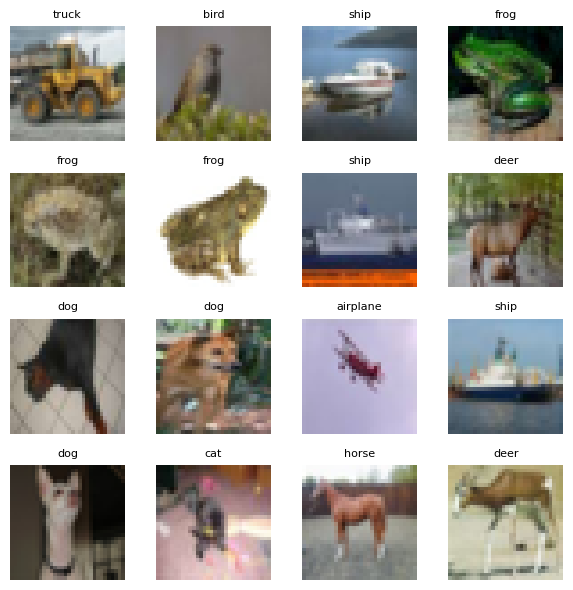

In [17]:
def unnormalize(img):
  img = img/2 + 0.5
  return img.numpy()

dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images[:16]

fig, axes = plt.subplots(4, 4, figsize = (6,6))
for i, ax in enumerate(axes.flat):
  img = unnormalize(images[i])
  img = np.transpose(img, (1, 2, 0))
  ax.imshow(img)
  ax.set_title(train_set.classes[labels[i]], fontsize=8)
  ax.axis('off')

plt.tight_layout()
plt.show()

In [18]:
class BaselineCNN1(nn.Module):
  def __init__(self):
    super(BaselineCNN1, self).__init__()

    self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding = 1) #input: 3*32*32 -> 32*32*32
    #will output 32 features
    self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)
    #will take 32 features and generate 64 feautres
    self.pool = nn.MaxPool2d(2, 2)
    #reduces size 32*32 into 16*16
    #will take each 2*2 pixel square as one
    self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1)
    self.conv4 = nn.Conv2d(128, 128, kernel_size = 3, padding = 1)

    self.fc = nn.Linear(128*8*8, 256)
    #will take 128*8*8 features and output 256
    #this is called flattening
    #8*8 because we've pooled twice
    self.output = nn.Linear(256, 10)
    #the final output layer, 10 outputs for 10 classes

  def forward(self, X):
    X = torch.relu(self.conv1(X))
    X = torch.relu(self.conv2(X))
    X = self.pool(X)

    X = torch.relu(self.conv3(X))
    X = torch.relu(self.conv4(X))
    X = self.pool(X)

    X = X.view(-1, 128*8*8) #flatten
    X = torch.relu(self.fc(X))
    X = self.output(X)

    return X


In [7]:
class BaselineCNN2(nn.Module):
  def __init__(self):
    super(BaselineCNN2, self).__init__()

    self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding = 1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1)
    self.conv4 = nn.Conv2d(128, 256, kernel_size = 3, padding = 1)

    self.fc1 = nn.Linear(256*8*8, 256)
    self.fc2 = nn.Linear(256, 128)
    self.output = nn.Linear(128, 10)

  def forward(self, X):
    X = torch.relu(self.conv1(X))
    X = torch.relu(self.conv2(X))
    X = self.pool(X)

    X = torch.relu(self.conv3(X))
    X = torch.relu(self.conv4(X))
    X = self.pool(X)

    X = X.view(-1, 256*8*8) #flatten
    X = torch.relu(self.fc1(X))
    X = torch.relu(self.fc2(X))
    X = self.output(X)

    return X


In [20]:
class BaselineCNN3(nn.Module):
  def __init__(self):
    super(BaselineCNN3, self).__init__()

    self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding = 1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size = 5, padding = 1)
    # -> 64*30*30
    self.conv3 = nn.Conv2d(64, 128, kernel_size = 5, padding = 1)
    # -> 64*28*28
    self.pool = nn.MaxPool2d(2, 2)
    # -> 64*14*14
    self.conv4 = nn.Conv2d(128, 128, kernel_size = 5, padding = 1)
    #->128*12*12

    self.fc1 = nn.Linear(128*12*12, 256)
    self.output = nn.Linear(256, 10)

  def forward(self, X):
    X = torch.relu(self.conv1(X))
    X = torch.relu(self.conv2(X))
    X = torch.relu(self.conv3(X))
    X = self.pool(X)

    X = torch.relu(self.conv4(X))

    X = X.view(-1, 128*12*12) #flatten
    X = torch.relu(self.fc1(X))
    X = self.output(X)

    return X


In [7]:
def train_models(models, train_loader, test_loader, epochs = 20, lr = 0.01, device="cuda"):
  criterion = nn.CrossEntropyLoss()
  histories = {}

  for name, model in models.items():
    print(f"Training {name}")
    model = model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum = 0.9, weight_decay = 5e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = epochs)
    # Cosine annealing: starts high, decreases gradually, then rises slightly again.
    # Helps models converge better than a fixed learning rate

    train_acc_hist, test_acc_hist = [], []

    for epoch in range(epochs):
      model.train()

      correct, total, running_loss = 0, 0, 0

      for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

      train_acc = 100. * correct/total
      train_acc_hist.append(train_acc)

      model.eval()
      correct, total = 0, 0

      with torch.no_grad():
        for images, labels in test_loader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          _, predicted = outputs.max(1)
          total += labels.size(0)
          correct += predicted.eq(labels).sum().item()

      test_acc = 100.*correct/total
      test_acc_hist.append(test_acc)

      scheduler.step()

      print(f"Epoch [{epoch+1}/{epochs}] "
                  f"Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")

    histories[name] = (train_acc_hist, test_acc_hist)

  return histories

In [12]:
initial_models = {
    "BaselineCNN1": BaselineCNN1(),
    "BaselineCNN2": BaselineCNN2(),
    "BaselineCNN3": BaselineCNN3()
                  }

histories = train_models(initial_models, train_loader, test_loader, epochs = 20)

Training BaselineCNN1
Epoch [1/20] Train Acc: 30.25% | Test Acc: 45.55%
Epoch [2/20] Train Acc: 52.87% | Test Acc: 56.65%
Epoch [3/20] Train Acc: 63.41% | Test Acc: 65.63%
Epoch [4/20] Train Acc: 69.96% | Test Acc: 70.31%
Epoch [5/20] Train Acc: 75.42% | Test Acc: 72.72%
Epoch [6/20] Train Acc: 80.77% | Test Acc: 73.70%
Epoch [7/20] Train Acc: 85.36% | Test Acc: 73.93%
Epoch [8/20] Train Acc: 90.25% | Test Acc: 75.05%
Epoch [9/20] Train Acc: 94.37% | Test Acc: 74.18%
Epoch [10/20] Train Acc: 97.47% | Test Acc: 75.00%
Epoch [11/20] Train Acc: 99.09% | Test Acc: 75.59%
Epoch [12/20] Train Acc: 99.88% | Test Acc: 76.33%
Epoch [13/20] Train Acc: 99.99% | Test Acc: 76.91%
Epoch [14/20] Train Acc: 100.00% | Test Acc: 76.97%
Epoch [15/20] Train Acc: 100.00% | Test Acc: 77.06%
Epoch [16/20] Train Acc: 100.00% | Test Acc: 77.10%
Epoch [17/20] Train Acc: 100.00% | Test Acc: 77.05%
Epoch [18/20] Train Acc: 100.00% | Test Acc: 77.01%
Epoch [19/20] Train Acc: 100.00% | Test Acc: 76.98%
Epoch [20/20

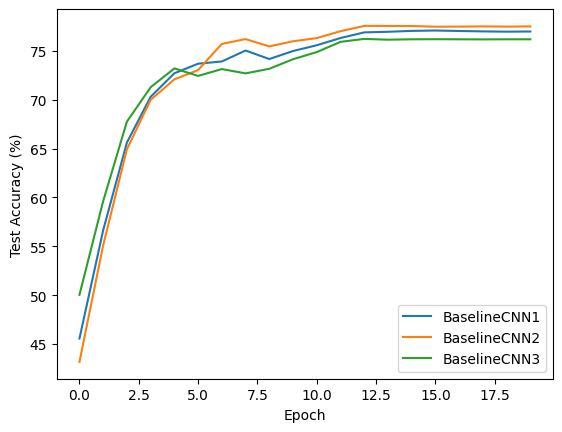

In [22]:
import matplotlib.pyplot as plt

for name, (train_hist, test_hist) in histories.items():
    plt.plot(test_hist, label=name)

plt.xlabel("Epoch")
plt.ylabel("Test Accuracy (%)")
plt.legend()
plt.show()

The models are overfitting by quite a lot. We will apply batch normalization, dropout and data augmentation serially to check their effects.

**Batch Normalization:**

We add batch normalization to BaselineCNN2 and check the improvement of accuracy.

In [6]:
class BaselineCNN2_BN(nn.Module):
    def __init__(self):
        super(BaselineCNN2_BN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.fc1 = nn.Linear(256*8*8, 256)
        self.fc2 = nn.Linear(256, 128)
        self.output = nn.Linear(128, 10)

    def forward(self, X):
        X = torch.relu(self.bn1(self.conv1(X)))
        X = torch.relu(self.bn2(self.conv2(X)))
        X = self.pool(X)

        X = torch.relu(self.bn3(self.conv3(X)))
        X = torch.relu(self.bn4(self.conv4(X)))
        X = self.pool(X)

        X = X.view(-1, 256*8*8)
        X = torch.relu(self.fc1(X))
        X = torch.relu(self.fc2(X))
        X = self.output(X)
        return X

In [5]:
class BaselineCNN1_BN(nn.Module):
    def __init__(self):
        super(BaselineCNN1_BN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        self.fc = nn.Linear(128*8*8, 256)
        self.output = nn.Linear(256, 10)

    def forward(self, X):
        X = torch.relu(self.bn1(self.conv1(X)))
        X = torch.relu(self.bn2(self.conv2(X)))
        X = self.pool(X)

        X = torch.relu(self.bn3(self.conv3(X)))
        X = torch.relu(self.bn4(self.conv4(X)))
        X = self.pool(X)

        X = X.view(-1, 128*8*8)
        X = torch.relu(self.fc(X))
        X = self.output(X)
        return X

In [19]:
check_bn_models = {
    "No_BN": BaselineCNN2(),
    "With_BN": BaselineCNN2_BN()
}

histories = train_models(check_bn_models, train_loader, test_loader, epochs=20, device=device)


Training No_BN
Epoch [1/20] Train Acc: 28.87% | Test Acc: 44.07%
Epoch [2/20] Train Acc: 48.64% | Test Acc: 53.37%
Epoch [3/20] Train Acc: 59.97% | Test Acc: 63.40%
Epoch [4/20] Train Acc: 68.17% | Test Acc: 67.95%
Epoch [5/20] Train Acc: 74.35% | Test Acc: 72.42%
Epoch [6/20] Train Acc: 80.00% | Test Acc: 71.77%
Epoch [7/20] Train Acc: 85.02% | Test Acc: 73.76%
Epoch [8/20] Train Acc: 90.30% | Test Acc: 74.43%
Epoch [9/20] Train Acc: 94.55% | Test Acc: 75.35%
Epoch [10/20] Train Acc: 97.53% | Test Acc: 75.06%
Epoch [11/20] Train Acc: 98.96% | Test Acc: 76.05%
Epoch [12/20] Train Acc: 99.80% | Test Acc: 76.43%
Epoch [13/20] Train Acc: 99.99% | Test Acc: 77.08%
Epoch [14/20] Train Acc: 100.00% | Test Acc: 76.97%
Epoch [15/20] Train Acc: 100.00% | Test Acc: 77.09%
Epoch [16/20] Train Acc: 100.00% | Test Acc: 77.10%
Epoch [17/20] Train Acc: 100.00% | Test Acc: 77.00%
Epoch [18/20] Train Acc: 100.00% | Test Acc: 76.99%
Epoch [19/20] Train Acc: 100.00% | Test Acc: 77.01%
Epoch [20/20] Train

As we can see, batch normalization increases the accuracy by a good margin.

**Data Augmentation**

Both BaselineCNN1 and BaselineCNN2 will be taken - batch normalization and data augmentation will be added.

In [2]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding = 4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

In [3]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                           shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100,
                                          shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:14<00:00, 12.0MB/s]


In [11]:
check_aug_models = {
    "BaselineCNN1_BN+Aug": BaselineCNN1_BN(),
    "BaselineCNN2_BN+Aug": BaselineCNN2_BN()
}

histories = train_models(check_aug_models, train_loader, test_loader, epochs=20, device=device)

Training BaselineCNN1_BN+Aug
Epoch [1/20] Train Acc: 47.44% | Test Acc: 61.83%
Epoch [2/20] Train Acc: 63.93% | Test Acc: 67.74%
Epoch [3/20] Train Acc: 69.06% | Test Acc: 69.86%
Epoch [4/20] Train Acc: 72.84% | Test Acc: 73.12%
Epoch [5/20] Train Acc: 75.08% | Test Acc: 70.31%
Epoch [6/20] Train Acc: 77.02% | Test Acc: 76.61%
Epoch [7/20] Train Acc: 78.39% | Test Acc: 76.69%
Epoch [8/20] Train Acc: 80.06% | Test Acc: 80.16%
Epoch [9/20] Train Acc: 81.24% | Test Acc: 79.86%
Epoch [10/20] Train Acc: 82.62% | Test Acc: 80.45%
Epoch [11/20] Train Acc: 83.55% | Test Acc: 83.58%
Epoch [12/20] Train Acc: 84.72% | Test Acc: 83.26%
Epoch [13/20] Train Acc: 85.27% | Test Acc: 84.73%
Epoch [14/20] Train Acc: 86.39% | Test Acc: 84.21%
Epoch [15/20] Train Acc: 86.95% | Test Acc: 84.34%
Epoch [16/20] Train Acc: 87.57% | Test Acc: 85.68%
Epoch [17/20] Train Acc: 88.25% | Test Acc: 86.27%
Epoch [18/20] Train Acc: 88.62% | Test Acc: 86.57%
Epoch [19/20] Train Acc: 88.96% | Test Acc: 86.59%
Epoch [20/2

Now we add rotation and colorjitter to check if accuracy improves.

In [12]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding = 4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

In [13]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                           shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100,
                                          shuffle=False, num_workers=2)

In [14]:
check_aug2_models = {
    "BaselineCNN1_BN+Aug(v2)": BaselineCNN1_BN(),
    "BaselineCNN2_BN+Aug(v2)": BaselineCNN2_BN()
}

histories = train_models(check_aug2_models, train_loader, test_loader, epochs=20, device=device)

Training BaselineCNN1_BN+Aug(v2)
Epoch [1/20] Train Acc: 41.23% | Test Acc: 53.38%
Epoch [2/20] Train Acc: 53.93% | Test Acc: 61.99%
Epoch [3/20] Train Acc: 60.75% | Test Acc: 66.53%
Epoch [4/20] Train Acc: 65.35% | Test Acc: 73.25%
Epoch [5/20] Train Acc: 68.23% | Test Acc: 72.61%
Epoch [6/20] Train Acc: 70.13% | Test Acc: 74.89%
Epoch [7/20] Train Acc: 72.29% | Test Acc: 77.83%
Epoch [8/20] Train Acc: 73.75% | Test Acc: 78.33%
Epoch [9/20] Train Acc: 75.06% | Test Acc: 80.65%
Epoch [10/20] Train Acc: 76.55% | Test Acc: 79.59%
Epoch [11/20] Train Acc: 77.31% | Test Acc: 80.38%
Epoch [12/20] Train Acc: 78.31% | Test Acc: 81.55%
Epoch [13/20] Train Acc: 79.30% | Test Acc: 83.29%
Epoch [14/20] Train Acc: 80.02% | Test Acc: 83.17%
Epoch [15/20] Train Acc: 81.07% | Test Acc: 83.97%
Epoch [16/20] Train Acc: 81.40% | Test Acc: 83.92%
Epoch [17/20] Train Acc: 82.11% | Test Acc: 84.15%
Epoch [18/20] Train Acc: 82.33% | Test Acc: 84.47%
Epoch [19/20] Train Acc: 82.64% | Test Acc: 84.66%
Epoch [

It's clear that rot and jitt no help, fix. and bnn2 besto, so add droupout

In [ ]:
class BaselineCNN2_BN_Drop(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1); self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1); self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1); self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1); self.bn4 = nn.BatchNorm2d(256)
        self.dropout_conv = nn.Dropout(p=0.1)      # optional, low-rate
        self.fc1 = nn.Linear(256*8*8, 256)
        self.dropout_fc = nn.Dropout(p=0.5)        # main dropout
        self.fc2 = nn.Linear(256, 128)
        self.output = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = torch.relu(self.bn3(self.conv3(x)))
        x = torch.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = self.dropout_conv(x)                    # optional
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = torch.relu(self.fc2(x))
        return self.output(x)

In [ ]:
transform_train = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465),
                (0.2023, 0.1994, 0.2010)),
    T.RandomErasing(p=0.25, scale=(0.02, 0.12), ratio=(0.3, 3.3))
])